# lesson_3_DAN_CNN_RNN_Word2Vec_Embeddings_Classifier_plus_Attention

**Description:** Text classification on the IMDB movie dataset using i) Deep Averaging Networks, and ii) Convolutions Neural Nets (CNN) and pre-trained Word2Vec word embeddings.<br>

Section 1 deals with setup and prerequisites, can does not deserve a lot of discussion.
Data acquisition and preparation are handled in section 2, and section 3 looks at DANs and CNNs and now RNNs.


<a id = 'returnToTop'></a>


## IMPORTANT NOTE:
Because of the environment built in to Colab, the software we're importing causes an error to be thrown the first time you run the cells in the Setup section.  As soon as you hit the error, you have to go to the Runtime menu and select 'Restart Session'.  Once the session is restarted you must rerun the cells in Setup and you will not run in to the error.


## Notebook Contents
  * 1. [Setup](#setup)
  * 2. [Creation of the Dataset](#creationOfDataset)  
  * 3. [Modeling](#modeling)
    * 3.1 [Averaging Network](#averagingNetwork)
    * 3.2 [Deep Averaging Network (DAN)](#modelDAN)
    * 3.3 [Convolutional Neural Net (CNN)](#modelCNN)
    * 3.4 [Recurrent Neural Net (RNN)](#modelRNN)
       * 3.4.2 [Class Exercise](#classExercise)
  * 4. [What about Attention](#modelAttention)
  * 5. [Answers](#answers)
  
  
  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2025-fall-main/blob/master/materials/lesson_notebooks/lesson_3_adding_RNNs_and_attention_to_classification_notebook.ipynb)

[Return to Top](#returnToTop)  
<a id = 'setup'></a>
## 1. Setup

While it doesn't require a GPU, this notebook should be run on Colab.

## IMPORTANT NOTE:
Because of the environment built in to Colab, the software we're importing causes an error to be thrown the first time you run the cells in the Setup section.  As soon as you hit the error, you have to go to the Runtime menu and select 'Restart Session'.  Once the session is restarted you must rerun the cells in Setup and you will not run in to the error.


Ready to do the imports.

In [36]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"


import numpy as np
import tensorflow as tf
import keras

from keras.layers import Embedding, Input, Dense, Lambda
from keras.models import Model
# import keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re


import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

Below is a helper function to plot histories.

In [37]:
# 4-window plot of loss and accuracy for two models, for comparison
def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2'):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # ------------------------------------------------------
        # Compute shared y-limits across both models
        # ------------------------------------------------------
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        # ------------------------------------------------------
        # Plot both training and validation curves for each model
        # ------------------------------------------------------
        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]

            # Plot training curve
            ax1.plot(
                model_history.history[metric],
                label=f'Train {metric}'
            )

            # Plot validation curve
            ax1.plot(
                model_history.history[f'val_{metric}'],
                label=f'Val {metric}'
            )

            # Add title, labels, and limits
            ax1.set_title(f'{metric} - {model_name}')
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

            # Add legend (distinguish train vs val curves)
            ax1.legend(loc='best')


Next, we get the word2vec model from nltk.

In [38]:
nltk.download('word2vec_sample')

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /data/homezvol2/ddlin/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


True

In [39]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

In [40]:
vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

How many words are in the vocabulary?

In [41]:
len(vec_model)

43981

How do the word vectors look like? As expected:

In [42]:
vec_model['great']

array([ 3.06035e-02,  8.86877e-02, -1.21269e-02,  7.61965e-02,
        5.66269e-02, -4.24702e-02,  4.10129e-02, -4.97567e-02,
       -3.64328e-03,  6.32889e-02, -1.42608e-02, -7.91111e-02,
        1.74877e-02, -3.83064e-02,  9.26433e-03,  2.95626e-02,
        7.70293e-02,  9.49334e-02, -4.28866e-02, -2.95626e-02,
        4.45244e-05,  6.82854e-02,  1.73836e-02,  3.14363e-02,
        6.53708e-02,  2.89380e-02, -4.39275e-02,  1.78000e-02,
        1.82164e-02, -4.70503e-02, -2.85216e-02,  1.79041e-02,
        1.06592e-01,  9.07696e-02,  6.78690e-02,  6.16755e-03,
       -2.08187e-02,  5.95936e-03,  1.51586e-03,  8.95205e-02,
        6.49544e-02, -3.12281e-02,  9.24351e-02, -2.45661e-02,
       -1.21269e-02, -1.53538e-03,  6.49544e-02, -1.12421e-02,
        9.10819e-03, -6.45380e-02,  4.43439e-02,  1.35738e-01,
       -7.91111e-02,  1.57181e-02, -4.72585e-02, -1.35322e-02,
       -4.33029e-02, -5.16304e-02,  1.37404e-01, -3.12281e-02,
       -6.49544e-02,  1.14087e-01, -6.41217e-02, -5.246

We can now build the embedding matrix and a vocabulary dictionary:

In [43]:
EMBEDDING_DIM = len(vec_model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(vec_model) + 1, EMBEDDING_DIM))
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(vec_model.index_to_key):
    embedding_vector = vec_model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [44]:
embedding_matrix.shape

(43982, 300)

In [45]:
embedding_matrix[:5, :5]

array([[ 0.0891758 ,  0.121832  , -0.0671959 ,  0.0477279 , -0.013659  ],
       [ 0.0526281 ,  0.013157  , -0.010104  ,  0.0540819 ,  0.0386715 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 ,  0.0347375 ,  0.0288273 ],
       [-0.00157585, -0.0564239 ,  0.00320281,  0.0422498 ,  0.15264399],
       [ 0.0356899 , -0.00367283, -0.065534  ,  0.0213832 ,  0.00788408]])

[Return to Top](#returnToTop)  
<a id = 'creationOfDataset'></a>
## 2. Creation of the Dataset

### 2.1 Data Acquisition

We will use the IMDB dataset delivered as part of the tensorflow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [46]:
train_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

In [47]:
train_examples, train_labels = next(iter(train_data.batch(20000)))
test_examples, test_labels = next(iter(test_data.batch(5000)))

In [48]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [49]:
train_labels[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 1])>

Next, we tokenize the data:

In [50]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(test_examples)

Does this look right?

In [51]:
train_tokens[0]

<tf.Tensor: shape=(116,), dtype=string, numpy=
array([b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.',
       b"Don't", b'be', b'lured', b'in', b'by', b'Christopher', b'Walken',
       b'or', b'Michael', b'Ironside.', b'Both', b'are', b'great',
       b'actors,', b'but', b'this', b'must', b'simply', b'be', b'their',
       b'worst', b'role', b'in', b'history.', b'Even', b'their', b'great',
       b'acting', b'could', b'not', b'redeem', b'this', b"movie's",
       b'ridiculous', b'storyline.', b'This', b'movie', b'is', b'an',
       b'early', b'nineties', b'US', b'propaganda', b'piece.', b'The',
       b'most', b'pathetic', b'scenes', b'were', b'those', b'when',
       b'the', b'Columbian', b'rebels', b'were', b'making', b'their',
       b'cases', b'for', b'revolutions.', b'Maria', b'Conchita',
       b'Alonso', b'appeared', b'phony,', b'and', b'her', b'pseudo-love',
       b'affair', b'with', b'Walken', b'was', b'nothing', b'but', b'a',
       b'pathetic', b'emotional', b

Yup... looks right. Of course we will need to take care of the encoding later.

### 2.2 Data Preparation

For the models we will use, we need to define a maximum sequence length (max number of tokens per movie review that we'll feed into our model). We'll cut off any tokens longer than that, and we'll pad shorter movie reviews with zeros at the end.

In [52]:
MAX_SEQUENCE_LENGTH = 128

Next, we define a simple function that converts the tokens of each movie review into their word2vec vocabulary index values.   

In [53]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])

        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)

        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

Now we can create training and test data that can be fed into the models of interest.

In [54]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Total examples:  19999
Examples processed:  0
Total examples:  4999


Let's convince ourselves that the data looks correct.  We expect the train data to be an array of integer ids and the labels to be an array of zeroes and ones (since we are learning a binary classifier).

In [55]:
train_input[:2]

array([[21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
        35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
        42958,  5589,  8092, 43981, 34516, 43981,  8092, 16182, 43981,
        39933, 43981, 12139,  2326, 32781, 32467,  7046, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
      

In [56]:
train_labels[:4]

array([0, 0, 0, 1])

[Return to Top](#returnToTop)  
<a id = 'modeling'></a>
## 3. Modeling

<a id = 'averagingNetwork'></a>
### 3.1 Averaging Network (AN) Model

Let us start by defining the embedding layer, then we'll average the embeddings and pass them into our classification layer.

In [57]:
an_input_layer = keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

In [58]:
an_embedding_layer = Embedding(embedding_matrix.shape[0],
                               embedding_matrix.shape[1],
                               embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False)

/share/crsp/lab/pkaiser/ddlin/mids/datasci-266/2025-fall-main/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [59]:
an_embeddings = an_embedding_layer(an_input_layer)

Now lets define a layer that will take the embeddings for each of the words in an input sentence and create one averaged embedding to represent the sentence.

In [60]:
an_avg_embeddings = keras.layers.Lambda(lambda x: keras.ops.mean(x, axis=1), name='averaging')(an_embeddings)

Finally lets define our output layer.

In [61]:
an_classification = keras.layers.Dense(1,
                                          activation='sigmoid',
                                          name='an_classification')(an_avg_embeddings)

In [62]:
an_model = keras.models.Model(inputs=an_input_layer, outputs=[an_classification])

In [63]:
an_model.compile(loss='binary_crossentropy',
                 optimizer=keras.optimizers.Adam(learning_rate=0.001,
                                                    beta_1=0.9,
                                                    beta_2=0.999,
                                                    epsilon=1e-07,
                                                    amsgrad=False,
                                                    name='Adam'),
                 metrics=['accuracy'])

In [64]:
an_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 128, 300)       │    13,194,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ averaging (Lambda)              │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ an_classification (Dense)       │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,194,901 (50.33 MB)

 Trainable params: 301 (1.18 KB)

 Non-trainable params: 13,194,600 (50.33 MB)

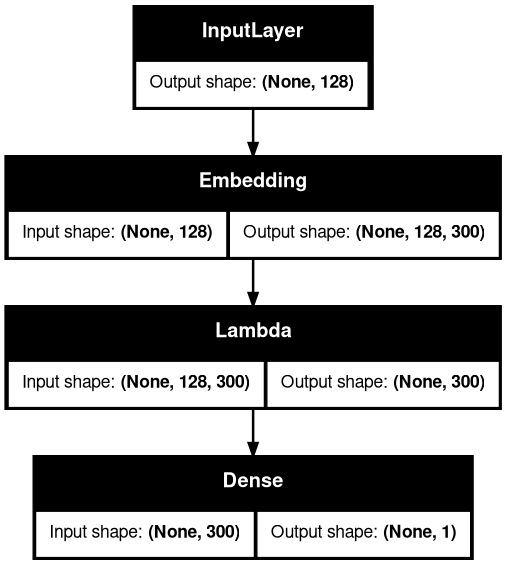

In [65]:
keras.utils.plot_model(an_model, show_shapes=True, dpi=90)

Let's look at the predictions and labels **before** training. Do those make sense?

In [66]:
print('predictions:\n', an_model.predict(train_input[:5]))
print('\n\nlabels:\n', train_labels[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


I0000 00:00:1757823406.460023 1352626 service.cc:152] XLA service 0x7f771016a4d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757823406.460057 1352626 service.cc:160]   StreamExecutor device (0): NVIDIA A30, Compute Capability 8.0
2025-09-13 21:16:46.467521: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1757823406.599053 1352626 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


predictions:
 [[0.49275666]
 [0.49417734]
 [0.49378115]
 [0.49302375]
 [0.49299443]]


labels:
 [0 0 0 1 1]


In [67]:
an_history = an_model.fit(train_input,
                          train_labels,
                          validation_data=(test_input, test_labels),
                          batch_size=32,
                          epochs=20
                          )

Epoch 1/20


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5786 - loss: 0.6882 - val_accuracy: 0.6196 - val_loss: 0.6842
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6410 - loss: 0.6782 - val_accuracy: 0.6408 - val_loss: 0.6758
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6636 - loss: 0.6693 - val_accuracy: 0.6462 - val_loss: 0.6688
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6658 - loss: 0.6616 - val_accuracy: 0.6576 - val_loss: 0.6618
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6737 - loss: 0.6545 - val_accuracy: 0.6618 - val_loss: 0.6558
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6764 - loss: 0.6482 - val_accuracy: 0.6654 - val_loss: 0.6506
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6817 - loss: 0.6424 - val_accuracy: 0.6700 - val_loss: 0.6453
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6845 - loss: 0.6369 - val_accuracy: 0.6744 - val_

Let's revisit the predictions. How is this?

In [68]:
print('predictions:\n', an_model.predict(train_input[:5]))
print('\n\nlabels:\n', train_labels[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
predictions:
 [[0.3157284 ]
 [0.30102414]
 [0.5840573 ]
 [0.6216555 ]
 [0.51665145]]


labels:
 [0 0 0 1 1]


That learned somewhat, can we do better?

[Return to Top](#returnToTop)  
<a id = 'modelDAN'></a>
### 3.2. Deep Averaging Network (DAN)

Now let's add some hidden layers after the averaging layer, to give our model more depth. The first and last layers are the same as above.

We'll also put our model creation code into a function, with variables for the things we can change (in this case, the hidden layers). Then we can try different values later.

In [69]:
def build_dan_model(hidden_layer_dims, dropout_rate, embeddings_trainable=False):
    dan_input_layer = keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    dan_embeddings = dan_embedding_layer(dan_input_layer)
    dan_avg_embeddings = keras.layers.Lambda(lambda x: keras.ops.mean(x, axis=1),
                                                name='averaging')(dan_embeddings)
    last_hidden_output = dan_avg_embeddings

    for i, h_dim in enumerate(hidden_layer_dims):
        last_hidden_output = keras.layers.Dense(h_dim, activation='relu',
                                                name='dan_hidden_%d' % i)(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(dropout_rate)(last_hidden_output)

    dan_classification = keras.layers.Dense(1,
                                            activation='sigmoid',
                                            name='dan_classification')(last_hidden_output)

    dan_model = keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])
    dan_model.compile(loss='binary_crossentropy',
                      optimizer=keras.optimizers.Adam(learning_rate=0.001,
                                                         beta_1=0.9,
                                                         beta_2=0.999,
                                                         epsilon=1e-07,
                                                         amsgrad=False,
                                                         name='Adam'),
                      metrics=['accuracy'])
    return dan_model

/share/crsp/lab/pkaiser/ddlin/mids/datasci-266/2025-fall-main/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


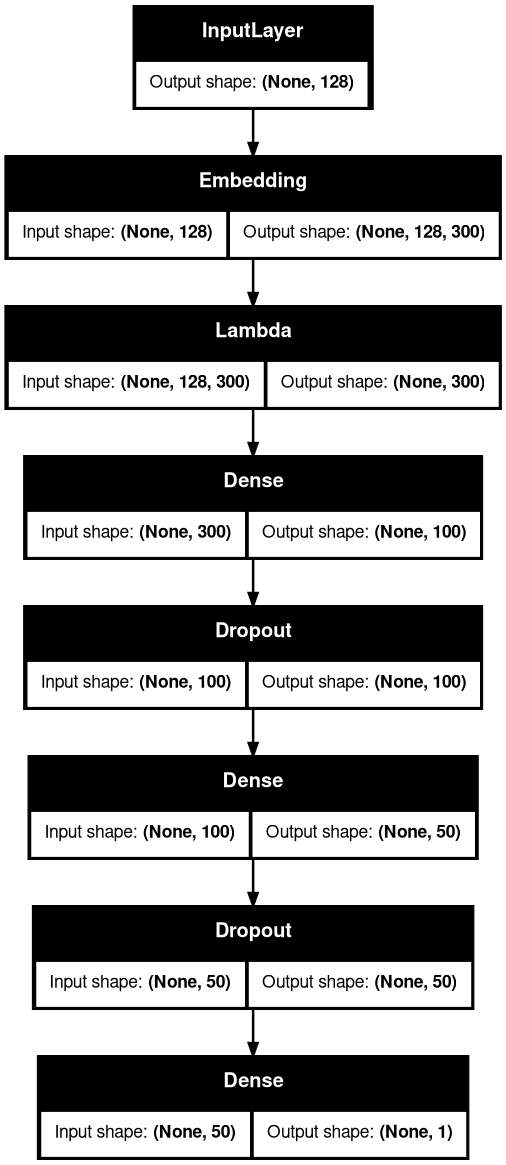

In [70]:
# Now call our function to create a DAN model, and show the model diagram

hidden_layer_sizes = [100, 50]
dropout_rate = 0.5

dan_model = build_dan_model(hidden_layer_sizes, dropout_rate)
keras.utils.plot_model(dan_model, show_shapes=True, dpi=90)

In [71]:
dan_history = dan_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=20
                            )

Epoch 1/20


2025-09-13 21:17:13.909191: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_784', 472 bytes spill stores, 472 bytes spill loads

2025-09-13 21:17:14.470645: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_784_0', 160 bytes spill stores, 160 bytes spill loads

2025-09-13 21:17:14.470676: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_784', 356 bytes spill stores, 356 bytes spill loads

2025-09-13 21:17:14.784083: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_784', 68 bytes spill stores, 68 bytes spill loads

2025-09-13 21:17:14.858112: I extern

620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5680 - loss: 0.6752

2025-09-13 21:17:22.379053: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42_0', 8 bytes spill stores, 8 bytes spill loads

2025-09-13 21:17:22.447470: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 232 bytes spill stores, 232 bytes spill loads

2025-09-13 21:17:22.787444: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 104 bytes spill stores, 104 bytes spill loads

2025-09-13 21:17:23.818499: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 104 bytes spill stores, 104 bytes spill loads

2025-09-13 21:17:24.672298: I external/loc

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.6284 - loss: 0.6404 - val_accuracy: 0.7120 - val_loss: 0.5619
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7384 - loss: 0.5334 - val_accuracy: 0.7538 - val_loss: 0.5043
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7570 - loss: 0.5107 - val_accuracy: 0.7608 - val_loss: 0.4929
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7640 - loss: 0.4966 - val_accuracy: 0.7682 - val_loss: 0.4860
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7667 - loss: 0.4898 - val_accuracy: 0.7646 - val_loss: 0.4808
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7714 - loss: 0.4823 - val_accuracy: 0.7686 - val_loss: 0.4763
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7696 - loss: 0.4793 - val_accuracy: 0.7764 - val_loss: 0.4705
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7759 - loss: 0.4761 - val_accuracy: 0.7754 - va

Below is a sample plot for two different models:

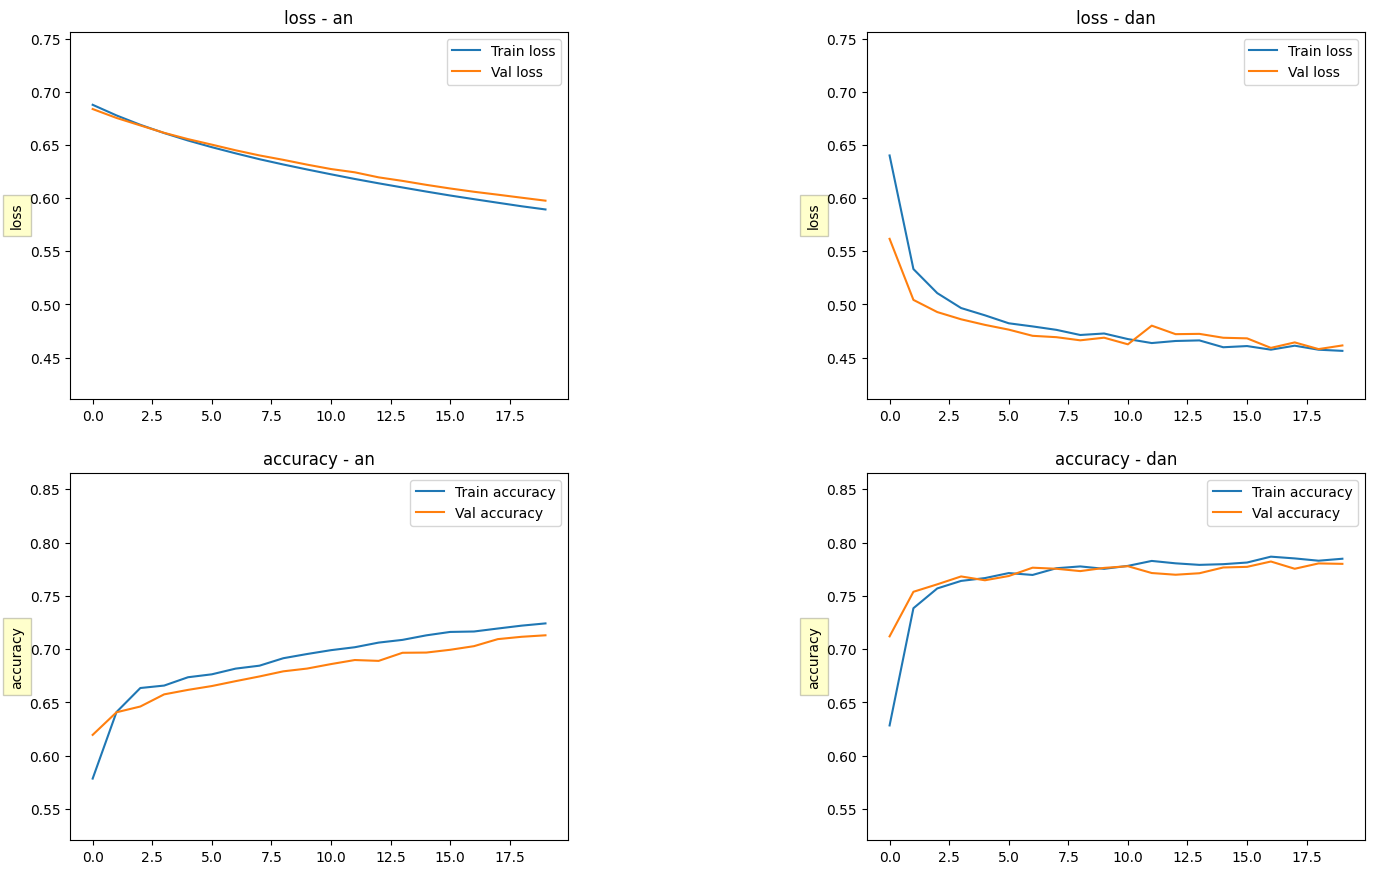

In [72]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          an_history,
          dan_history,
          model_1_name='an',
          model_2_name='dan')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

Of course, the avergaing network is not done training.

[Return to Top](#returnToTop)  
<a id = 'modelCNN'></a>
### 3.3 CNN Model

Next let's build a CNN model. We'll also wrap the model building code in a function that takes some hyperparameters, so that we can adjust things like number of filters and filter sizes later.

In [73]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    cnn_input_layer = keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)

    cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return cnn_model

In [74]:
# Now specify model hyperparameters and call the function to create a CNN model

num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

/share/crsp/lab/pkaiser/ddlin/mids/datasci-266/2025-fall-main/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [75]:
cnn_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 128, 300)  │ 13,194,600 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 126, 100)  │     90,100 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 125, 100)  │    120,100 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 124, 50)   │     75,050 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 119, 25)   │     75,025 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 50)        │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 25)        │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 275)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 275)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100)       │     27,600 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 50)        │      5,050 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         51 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,587,576 (51.83 MB)

 Trainable params: 392,976 (1.50 MB)

 Non-trainable params: 13,194,600 (50.33 MB)

The keras plot utility shows this probably a bit nicer:

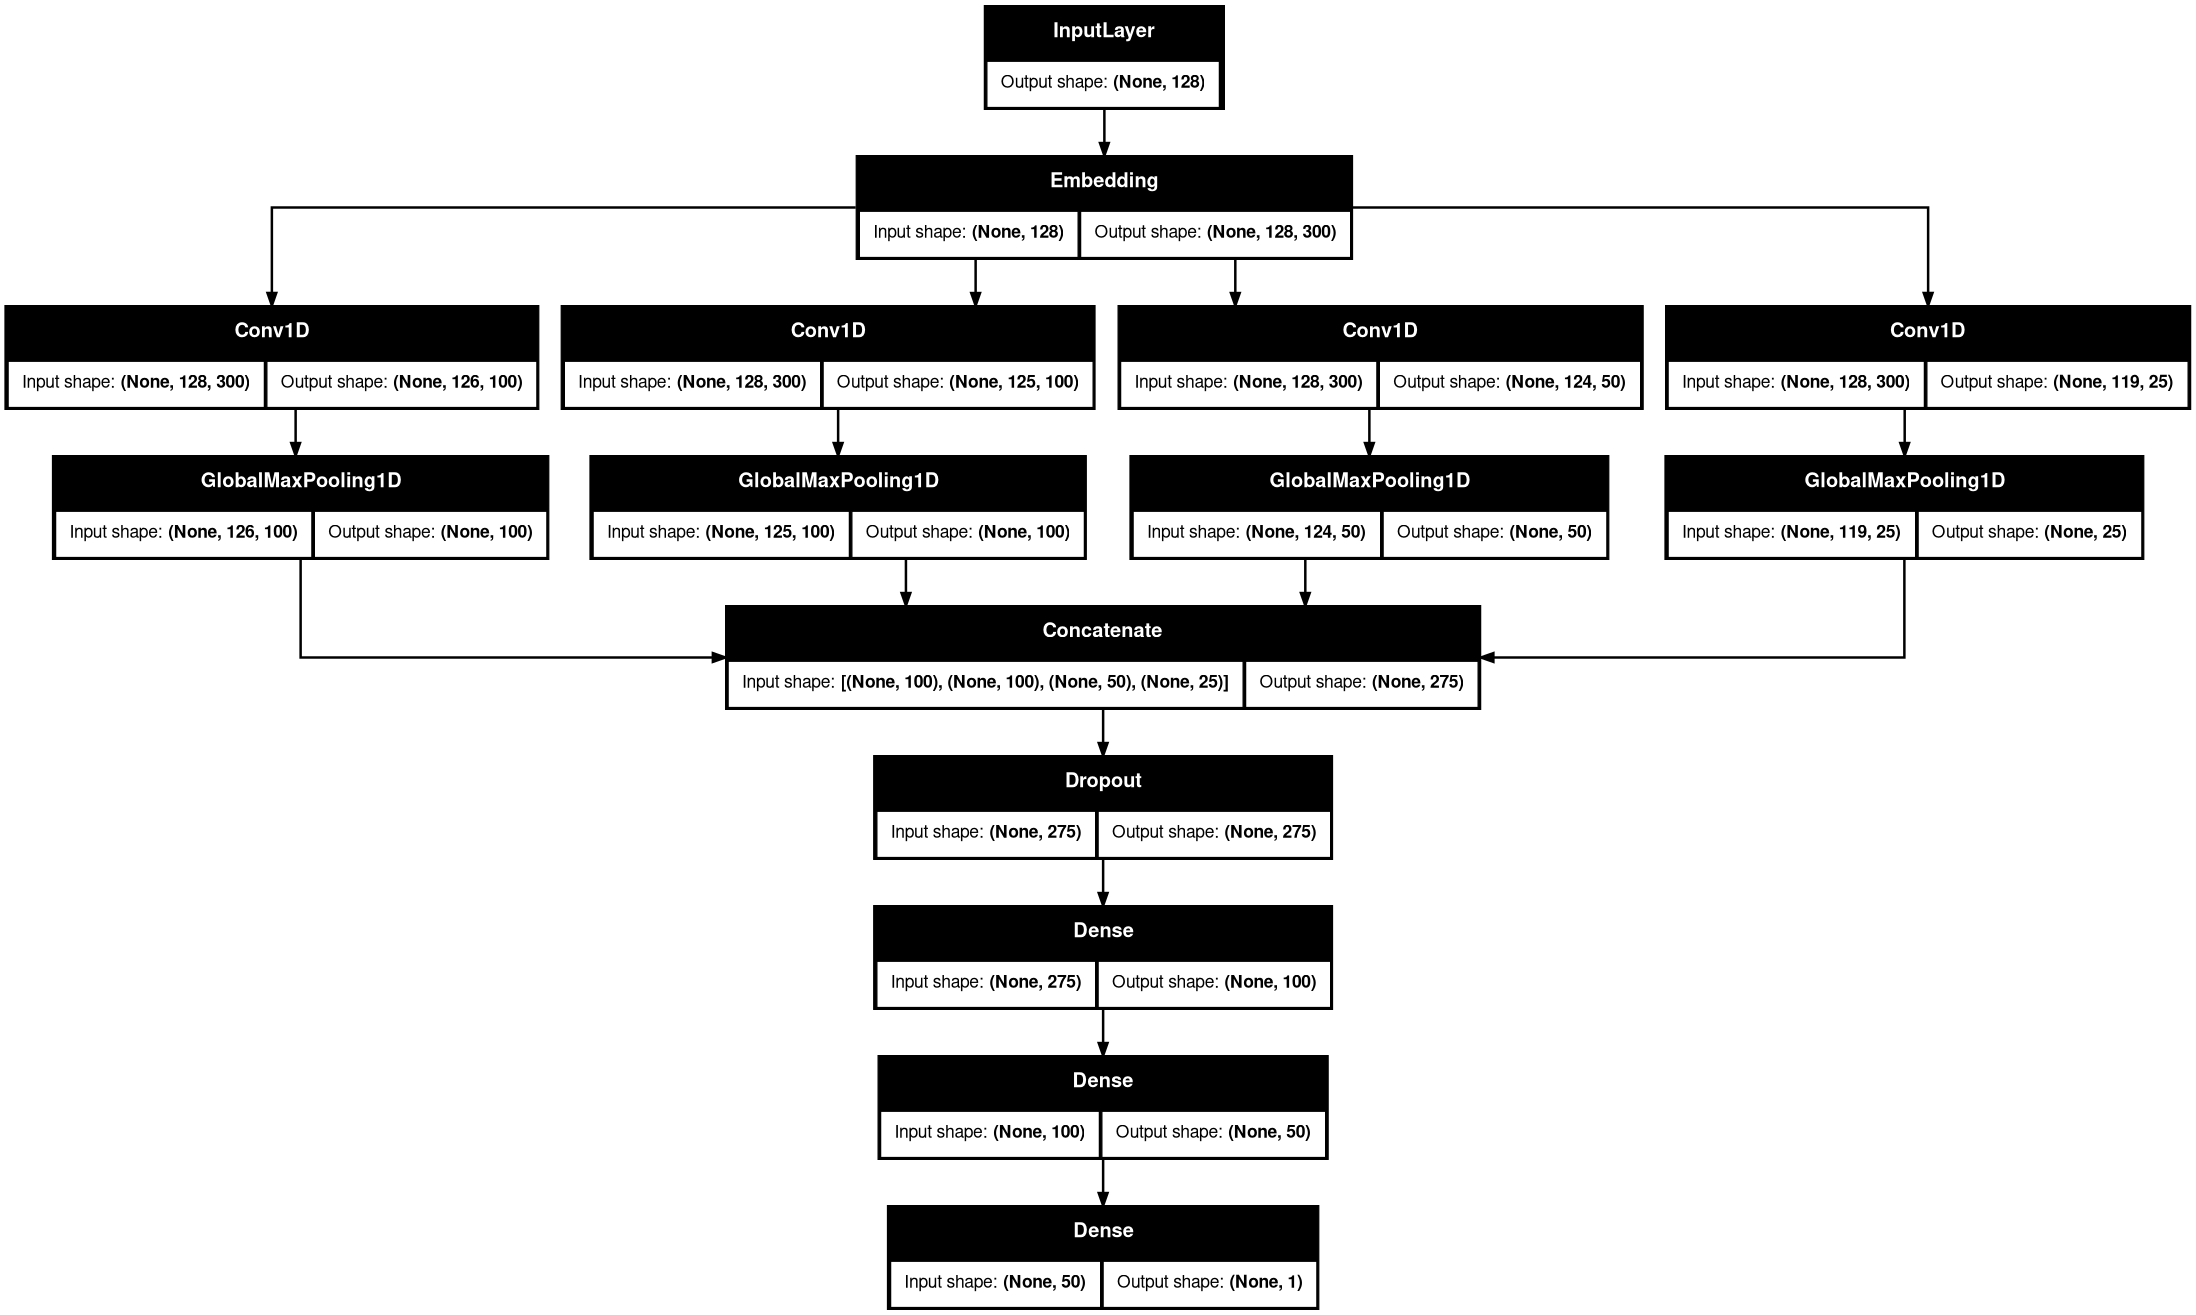

In [76]:
keras.utils.plot_model(cnn_model, show_shapes=True, dpi=90)

In [77]:
cnn_history = cnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5


625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7093 - loss: 0.5431 - val_accuracy: 0.8014 - val_loss: 0.4335
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8054 - loss: 0.4206 - val_accuracy: 0.8134 - val_loss: 0.4058
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8377 - loss: 0.3653 - val_accuracy: 0.8170 - val_loss: 0.4020
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8615 - loss: 0.3190 - val_accuracy: 0.8226 - val_loss: 0.4070
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8845 - loss: 0.2751 - val_accuracy: 0.8190 - val_loss: 0.4097


Below is a comparison of a CNN model with a DAN model:

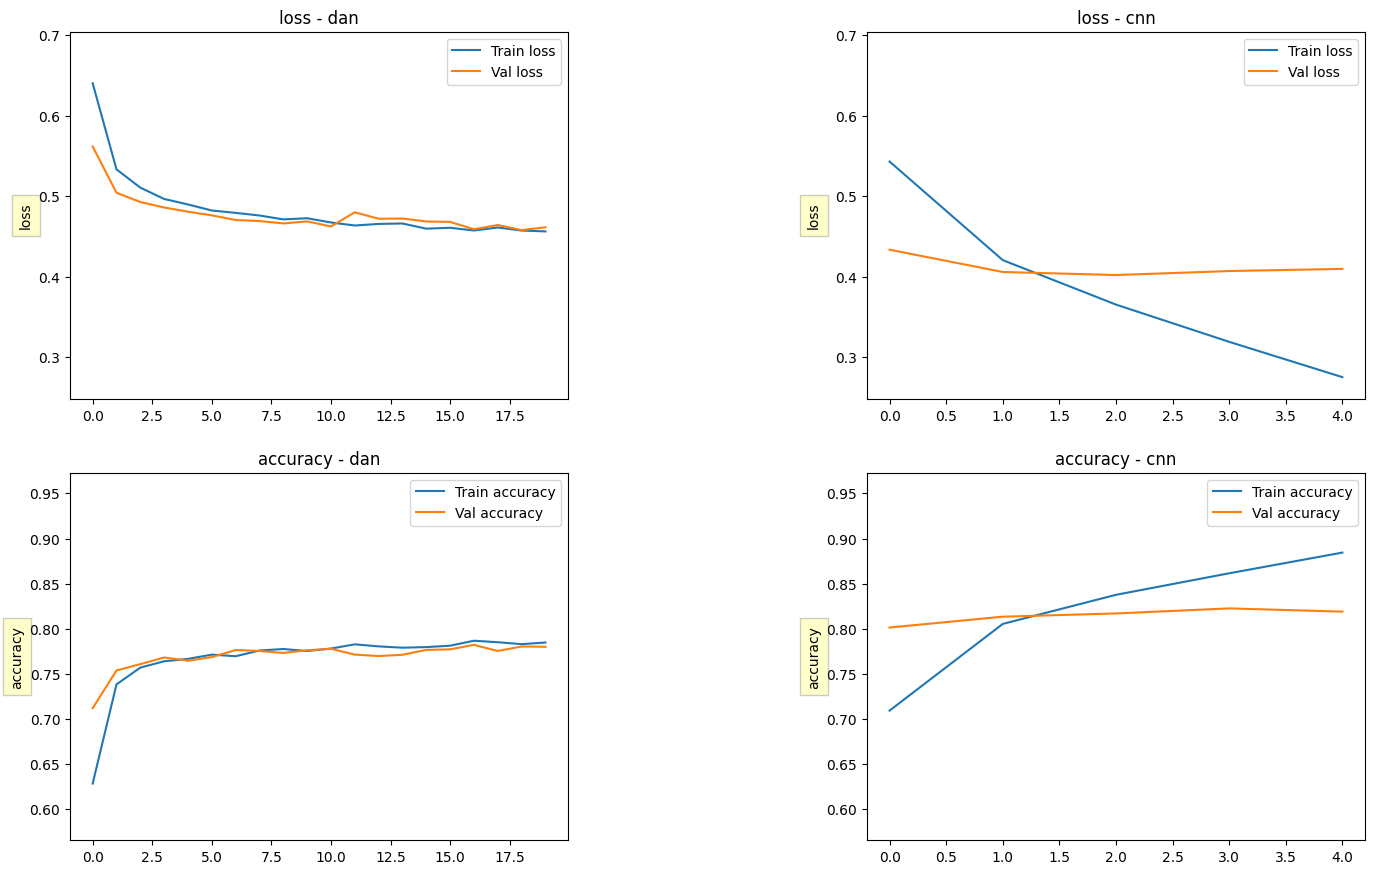

In [78]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          dan_history,
          cnn_history,
          model_1_name='dan',
          model_2_name='cnn')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

[Return to Top](#returnToTop)  
<a id = 'modelRNN'></a>
### 3.4 Recurrent Neural Network (RNN)

We now will now look at RNNs. We will first use a simple example to look at the structure of the model, and then use it also for classification of the same dataset that we used above.

#### 3.4.1. Basic Tests

Here is a very simple LSTM model with Keras.  For more details on much more complex uses of RNNs, see [this older Keras blog](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html).


✅ **Key points clarified:**

* Input is `(max_length, rnn_dim)` sequence per example.
* You also explicitly pass initial hidden state `h` and cell state `c`.
* Outputs vary depending on `return_sequences` and `return_state`:

  * `return_sequences=True, return_state=False` → full sequence only.
  * `return_sequences=False, return_state=True` → final output + states.
  * `True, True` → sequence + final states.



In [79]:
def build_basic_rnn_model(max_length,
                          rnn_dim,
                          return_sequences,
                          return_state):
    """
    Build a basic RNN model with a single LSTM layer that accepts an input
    sequence plus initial hidden and cell states.

    Parameters
    ----------
    max_length : int
        Maximum sequence length (number of time steps).
    rnn_dim : int
        Dimensionality of both the input vectors and the LSTM hidden states.
    return_sequences : bool
        If True → return the output for *every* time step
        (shape = (batch_size, max_length, rnn_dim)).
        If False → return only the final output
        (shape = (batch_size, rnn_dim)).
    return_state : bool
        If True → also return the final hidden state (h) and cell state (c).
        If False → return only the sequence outputs.

    Returns
    -------
    model : keras.Model
        Keras model object with three inputs (sequence, h, c) and one or
        more outputs depending on the flags.
    """

    # ------------------------------------------------------------
    # Step 1: Define inputs
    # ------------------------------------------------------------
    # Sequence input (shape = max_length x rnn_dim).
    #   - batch_size is implicit.
    #   - Each time step has a vector of size rnn_dim.
    in_x = keras.layers.Input(
        shape=(max_length, rnn_dim),
        name="in_id"
    )

    # Initial hidden state input (h), shape = (rnn_dim,)
    in_state_h = keras.layers.Input(
        shape=(rnn_dim,),
        name="in_state_h"
    )

    # Initial cell state input (c), shape = (rnn_dim,)
    in_state_c = keras.layers.Input(
        shape=(rnn_dim,),
        name="in_state_c"
    )

    # ------------------------------------------------------------
    # Step 2: Define the LSTM layer
    # ------------------------------------------------------------
    # - rnn_dim units (output dimension = hidden size)
    # - return_sequences: controls whether outputs are given
    #   for each time step (True) or just the last step (False).
    # - return_state: controls whether the final states (h, c)
    #   are included in the outputs.
    lstm_layer = keras.layers.LSTM(
        units=rnn_dim,
        return_sequences=return_sequences,
        return_state=return_state
    )

    # Apply the LSTM to the input sequence, using given initial states.
    # Depending on flags, lstm_output could be:
    #   - a single tensor (outputs)
    #   - or a tuple: (outputs, final_h, final_c)
    lstm_output = lstm_layer(
        in_x,
        initial_state=[in_state_h, in_state_c]
    )

    # ------------------------------------------------------------
    # Step 3: Build the model
    # ------------------------------------------------------------
    # Inputs: sequence + initial states
    # Outputs: LSTM outputs (and optionally final states)
    model = keras.models.Model(
        inputs=[in_x, in_state_h, in_state_c],
        outputs=lstm_output
    )

    return model


In [80]:
basic_rnn_model = build_basic_rnn_model(max_length=4,
                                        rnn_dim=3,
                                        return_sequences=True,
                                        return_state=True)

In [81]:
basic_rnn_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ in_id (InputLayer)  │ (None, 4, 3)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_state_h          │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_state_c          │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 4, 3),    │         84 │ in_id[0][0],      │
│                     │ (None, 3), (None, │            │ in_state_h[0][0], │
│                     │ 3)]               │            │ in_state_c[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84 (336.00 B)

 Trainable params: 84 (336.00 B)

 Non-trainable params: 0 (0.00 B)

**Questions:**

- do the output shapes look correct?
- is '84' the correct number of parameters?
- how do we calculate that number?



Great questions—let’s check shapes and the parameter count for your LSTM.

# 1) Output shapes (given your code)

Input `in_x` has shape `(batch, max_length, rnn_dim)` and the LSTM has `units = rnn_dim`.

* `return_sequences=False, return_state=False`
  Output: `(batch, rnn_dim)` (only the last timestep’s output)

* `return_sequences=True, return_state=False`
  Output: `(batch, max_length, rnn_dim)` (output at every timestep)

* `return_sequences=False, return_state=True`
  Output tuple:

  * `y`: `(batch, rnn_dim)` (last output)
  * `h`: `(batch, rnn_dim)` (final hidden state)
  * `c`: `(batch, rnn_dim)` (final cell state)

* `return_sequences=True, return_state=True`
  Output tuple:

  * `Y`: `(batch, max_length, rnn_dim)` (all outputs)
  * `h`: `(batch, rnn_dim)`
  * `c`: `(batch, rnn_dim)`

# 2) Is “84” the correct number of parameters?

It is correct **if** `rnn_dim = 3` and biases are enabled (Keras default).

# 3) How to calculate LSTM parameters

Keras LSTM has, per gate (there are 4 gates: input, forget, cell, output):

* Input kernel $W$: shape $(\text{input\_dim}, \text{units})$
* Recurrent kernel $U$: shape $(\text{units}, \text{units})$
* Bias $b$: shape $(\text{units},)$

Total parameters:

$$
4 \times \big( \text{input\_dim}\cdot \text{units} \;+\; \text{units}\cdot \text{units} \;+\; \text{units} \big)
$$

In your setup, $\text{input\_dim}=\text{units}=\text{rnn\_dim}=d$. So:

$$
\text{params} = 4 \times (d\cdot d + d\cdot d + d)
= 4 \times (2d^2 + d)
= 8d^2 + 4d
$$

Plugging $d=3$:

$$
8(3)^2 + 4(3) = 8\cdot 9 + 12 = 72 + 12 = 84.
$$

Notes:

* Turning **bias off** would subtract $4d$ (you’d get $8d^2$; for $d=3$, that’s 72).
* The **initial states** (`in_state_h`, `in_state_c`) are **inputs**, not trainable parameters, so they don’t change the parameter count.
* Dropout/recurrent\_dropout settings don’t change the count either; they change computation only.


Recurrent neural nets have multiple inputs and outputs.  We can put these recurrent networks together in interesting sequences.  Here are four different such configurations:

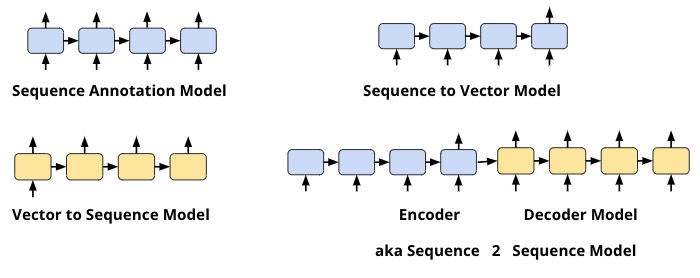

[Return to Top](#returnToTop)  
<a id = 'classExercise'></a>

Awesome prompt — here’s a crisp cheat-sheet you can use in class.

---

### Sequence Annotation (input: sequence → output: sequence, one label per timestep)

**What it’s good for (token-level tasks):**

* POS tagging, morphological tagging
* Named entity recognition (NER), chunking (BIO/BILOU)
* Slot filling in task-oriented dialogue
* Punctuation restoration, capitalization restoration
* Token-level sentiment or toxicity tags
* CTC/alignments (ASR token labeling)

---

### Sequence → Vector (input: sequence → output: single vector / label)

**What it’s good for (whole-sequence classification/regression):**

* Sentiment classification (review → positive/negative)
* Topic/category classification, spam detection, intent detection
* Author/language identification, readability score, quality estimation
* Semantic similarity (encode each text, then compare vectors)
* Next-step: feed this vector to downstream models

---

### Vector → Sequence (input: one vector → output: sequence)

**What it’s good for (generation from a fixed conditioning signal):**

* Image captioning (image encoder → caption decoder)
* Class- or style-conditioned text generation (condition vector → text)
* Speaker-conditioned speech synthesis (speaker embedding → waveform/phoneme seq)
* Any decoder that starts from a single context vector and then generates tokens

> Think: you hand the decoder *one* vector (not a full input sequence) and it unfolds a sequence.

---

### Sequence → Sequence (encoder–decoder)

**What it’s good for (full seq2seq transduction):**

* Machine translation, transliteration
* Summarization (doc → summary), headline generation
* Grammatical error correction, spelling correction
* Data-to-text / table-to-text, code generation
* Generative QA and dialog (context sequence → answer sequence)

---

## How `return_sequences` and `return_state` change things (Keras RNN/LSTM/GRU)

* **`return_sequences=False`** (default):

  * Output = **last timestep only** → shape `(batch, units)`
  * Use for: sequence→vector tasks, or when feeding only the final summary to dense layers.

* **`return_sequences=True`**:

  * Output = **all timesteps** → shape `(batch, timesteps, units)`
  * Use for: sequence annotation (token labels), stacking RNNs (next RNN needs full sequence).

* **`return_state=False`** (default):

  * Don’t return hidden states.

* **`return_state=True`**:

  * Also returns final state(s):

    * GRU: final `h` → `(batch, units)`
    * LSTM: final `h` **and** `c` → two tensors `(batch, units)` each
  * Use for: passing encoder’s final state to a decoder, stateful generation, or truncated BPTT.

### Shape quick-table (LSTM with `units=U`, `timesteps=T`)

* `return_sequences=False, return_state=False` → `(batch, U)`
* `return_sequences=True,  return_state=False` → `(batch, T, U)`
* `return_sequences=False, return_state=True`  → `(batch, U)`, plus `h:(batch,U)`, `c:(batch,U)`
* `return_sequences=True,  return_state=True`  → `(batch, T, U)`, plus `h:(batch,U)`, `c:(batch,U)`

---

**Rule of thumb:**

* Token-level labeling → `return_sequences=True`.
* Whole-sequence classification → `return_sequences=False`.
* Encoder–decoder or state handoff → `return_state=True` (to grab `h`/`c`).


## 1. Why your RNN has relatively fewer parameters

* In your setup, the **LSTM hidden dimension (`rnn_dim`)** is 100.
* The formula for LSTM parameters is:

$$
\text{params} = 4 \times \Big( \text{input\_dim} \cdot \text{units} + \text{units} \cdot \text{units} + \text{units} \Big)
$$

where:

* `input_dim` = embedding dimension (say 300)
* `units` = hidden size (`rnn_dim`, here 100)

So parameters scale with both **input dimension** and **hidden size**, but only once (for the recurrent connections).

Compare this to a **fully connected dense layer**:

$$
\text{params} = (\text{input\_dim} \cdot \text{units}) + \text{units}
$$

Dense layers stack many more connections if your input vector is long.

---

## 2. CNN vs RNN vs DAN

* **CNN**: For each kernel, you learn weights across the entire embedding dimension × kernel width, times the number of filters. Lots of filters = lots of params.
* **DAN (Deep Averaging Network)**: Just uses Dense layers on averaged embeddings. Dense layers can have *many* weights if hidden sizes are big.
* **RNN (LSTM/GRU)**: Parameters are reused **at every time step**. The weight matrices don’t grow with sequence length — they’re shared across timesteps. This makes RNNs relatively parameter-efficient.

---

## 3. Is this normal?

Yes ✅

* RNNs are **time-efficient** but **parameter-light**, because the same LSTM cell is reused across the whole sequence.
* CNNs and DANs often need more parameters to capture patterns since they don’t share weights over time in the same way.

---

## 4. Trade-off

* **RNN fewer params** → less chance of overfitting, but slower training because it processes sequences step by step.
* **CNN more params** → more expressive, faster parallelization, but more risk of overfitting.
* **DAN super few params** → very fast, but can miss sequential order information.

---

✅ **Takeaway**:
It’s perfectly normal for your RNN model to report a lower parameter count than CNN or Dense-heavy models. That’s because RNNs reuse the *same* weights across timesteps rather than learning separate weights for each position.



In [82]:
basic_rnn_model_no_return_sequence = build_basic_rnn_model(max_length=4,
                                                           rnn_dim=3,
                                                           return_sequences=False,
                                                           return_state=True)

In [83]:
basic_rnn_model_no_return_sequence.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ in_id (InputLayer)  │ (None, 4, 3)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_state_h          │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_state_c          │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 3),       │         84 │ in_id[0][0],      │
│                     │ (None, 3), (None, │            │ in_state_h[0][0], │
│                     │ 3)]               │            │ in_state_c[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84 (336.00 B)

 Trainable params: 84 (336.00 B)

 Non-trainable params: 0 (0.00 B)

In [84]:
basic_rnn_model_no_return_state = build_basic_rnn_model(max_length=4,
                                                        rnn_dim=3,
                                                        return_sequences=True,
                                                        return_state=False)

In [85]:
basic_rnn_model_no_return_state.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ in_id (InputLayer)  │ (None, 4, 3)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_state_h          │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_state_c          │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 4, 3)      │         84 │ in_id[0][0],      │
│                     │                   │            │ in_state_h[0][0], │
│                     │                   │            │ in_state_c[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84 (336.00 B)

 Trainable params: 84 (336.00 B)

 Non-trainable params: 0 (0.00 B)

In [86]:
basic_rnn_model_no_return_state_no_sequences = build_basic_rnn_model(max_length=4,
                                                                     rnn_dim=3,
                                                                     return_sequences=False,
                                                                     return_state=False)

In [87]:
basic_rnn_model_no_return_state_no_sequences.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ in_id (InputLayer)  │ (None, 4, 3)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_state_h          │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_state_c          │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 3)         │         84 │ in_id[0][0],      │
│                     │                   │            │ in_state_h[0][0], │
│                     │                   │            │ in_state_c[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84 (336.00 B)

 Trainable params: 84 (336.00 B)

 Non-trainable params: 0 (0.00 B)

Does this look right? It does...

What about the output using toy inputs?

In [88]:
lstm_input = np.array([[[1.1,2,3], [4,5,6], [7,8,9], [10,11,12]]])
initial_h = np.array([[1.,4,3]]*1)
initial_c = np.array([[1,2,6]]*1)

out, state_h, state_c = basic_rnn_model.predict([lstm_input, initial_h, initial_c],
                                                batch_size=4)

print('output_vector', out)
print('out_state_h ', state_h)
print('out_state_c ', state_c)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


output_vector [[[ 0.20785119  0.18837564  0.00815648]
  [-0.01906432  0.01011091  0.03695869]
  [-0.01077638 -0.0120578   0.0101974 ]
  [-0.00299379 -0.00587323  0.00249744]]]
out_state_h  [[-0.00299379 -0.00587323  0.00249744]]
out_state_c  [[-0.33125904 -1.8044897   2.3462367 ]]


Looks correct.

#### 3.4.2. RNN for IMBD Classification

Now let's build the full RNN model we'll use for our sentiment classification problem. From the LSTM layer, we'll only use the output from the last timestep (after processing all tokens). In this task, we don't have labels for every token, just for the text as a whole.

In [89]:
def build_rnn_model(rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    """
    Build an RNN-based (LSTM) text classification model.

    Parameters
    ----------
    rnn_dim : int
        Number of hidden units in the LSTM layer.
    dense_layer_dims : list of int
        Sizes of fully connected dense layers after the LSTM output.
    dropout_rate : float
        Dropout rate applied after each dense layer to reduce overfitting.
    embeddings_trainable : bool, optional (default=False)
        Whether the pretrained embedding weights should be updated
        during training (True) or kept frozen (False).

    Returns
    -------
    rnn_model : keras.Model
        A compiled Keras model ready for training.
    """

    # ------------------------------------------------------------
    # Step 1: Input & Embedding
    # ------------------------------------------------------------
    # Input: sequences of integer vocab IDs (length = MAX_SEQUENCE_LENGTH)
    rnn_input_layer = keras.layers.Input(
        shape=(MAX_SEQUENCE_LENGTH,), dtype='int64'
    )

    # Embedding layer:
    # - Loads pretrained word vectors from embedding_matrix
    # - Maps vocab IDs → dense embeddings
    # - Set trainable=False to freeze, True to fine-tune
    rnn_embedding_layer = Embedding(
        input_dim=embedding_matrix.shape[0],    # vocab size
        output_dim=embedding_matrix.shape[1],   # embedding dimension
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=embeddings_trainable
    )
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)
    # Shape: (batch_size, MAX_SEQUENCE_LENGTH, embedding_dim)

    # ------------------------------------------------------------
    # Step 2: LSTM layer
    # ------------------------------------------------------------
    # Processes the sequence of embeddings.
    # - return_sequences=False → only output the last time step
    # - return_state=False     → don’t return (h, c) states separately
    rnn_output = keras.layers.LSTM(
        rnn_dim,
        return_sequences=False,
        return_state=False,
        name='LSTM'
    )(rnn_embeddings)
    # Shape: (batch_size, rnn_dim)

    last_hidden_output = rnn_output

    # ------------------------------------------------------------
    # Step 3: Dense hidden layers with dropout
    # ------------------------------------------------------------
    for dense_layer_dim in dense_layer_dims:
        # Fully connected hidden layer with ReLU activation
        last_hidden_output = keras.layers.Dense(
            dense_layer_dim,
            activation='relu'
        )(last_hidden_output)

        # Apply dropout regularization after each dense layer
        last_hidden_output = keras.layers.Dropout(
            rate=dropout_rate
        )(last_hidden_output)

    # ------------------------------------------------------------
    # Step 4: Output layer
    # ------------------------------------------------------------
    # Dense layer with sigmoid activation for binary classification.
    rnn_prediction = keras.layers.Dense(
        1,
        activation='sigmoid'
    )(last_hidden_output)
    # Shape: (batch_size, 1)

    # ------------------------------------------------------------
    # Step 5: Build & compile the model
    # ------------------------------------------------------------
    rnn_model = keras.Model(
        inputs=rnn_input_layer,
        outputs=rnn_prediction
    )

    rnn_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  # Standard for binary classification
        metrics=['accuracy']
    )

    return rnn_model


/share/crsp/lab/pkaiser/ddlin/mids/datasci-266/2025-fall-main/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


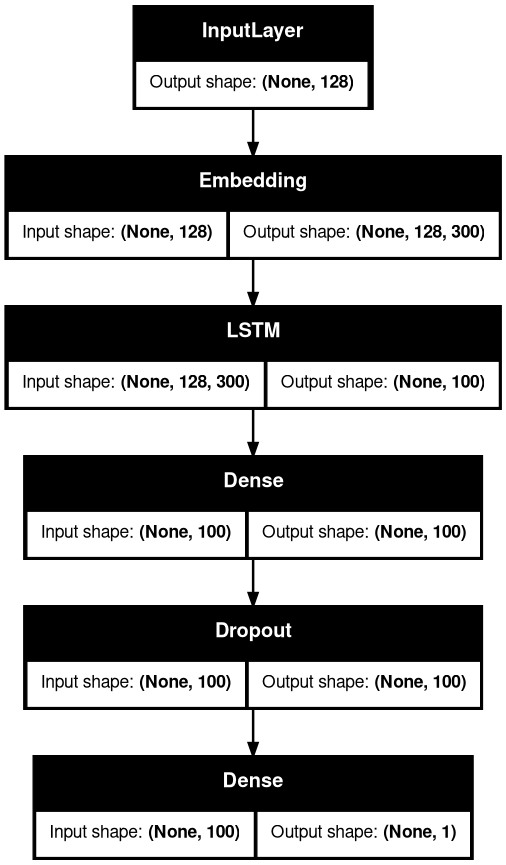

In [90]:
# ------------------------------------------------------------
# Step 1: Set hyperparameters for the RNN model
# ------------------------------------------------------------

# Number of hidden units in the LSTM layer
rnn_dim = 100

# Sizes of dense layers after the LSTM
# → here, a single dense layer with 100 units
dense_layer_dims = [100]

# Dropout rate applied after dense layers
# → randomly drop 50% of units during training to reduce overfitting
dropout_rate = 0.5

# ------------------------------------------------------------
# Step 2: Build the RNN model
# ------------------------------------------------------------
# Calls the build_rnn_model function we defined earlier.
#   - Uses embeddings (frozen, not trainable in this case).
#   - Architecture: Input → Embedding → LSTM(100) → Dense(100, relu) → Dropout(0.5) → Sigmoid output
rnn_model = build_rnn_model(
    rnn_dim,
    dense_layer_dims,
    dropout_rate,
    embeddings_trainable=False
)

# ------------------------------------------------------------
# Step 3: Visualize the model architecture
# ------------------------------------------------------------
# keras.utils.plot_model creates a diagram of the network.
# Parameters:
#   show_shapes=True → display tensor shapes at each layer
#   dpi=90          → resolution of the output image
keras.utils.plot_model(rnn_model, show_shapes=True, dpi=90)


In [91]:
rnn_history = rnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6086 - loss: 0.6629 - val_accuracy: 0.6816 - val_loss: 0.6266
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5602 - loss: 0.6809 - val_accuracy: 0.5032 - val_loss: 0.7136
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6888 - loss: 0.5914 - val_accuracy: 0.7572 - val_loss: 0.5194
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7528 - loss: 0.5207 - val_accuracy: 0.7782 - val_loss: 0.4797
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7788 - loss: 0.4796 - val_accuracy: 0.7920 - val_loss: 0.4671


Let's compare this to the CNN results:

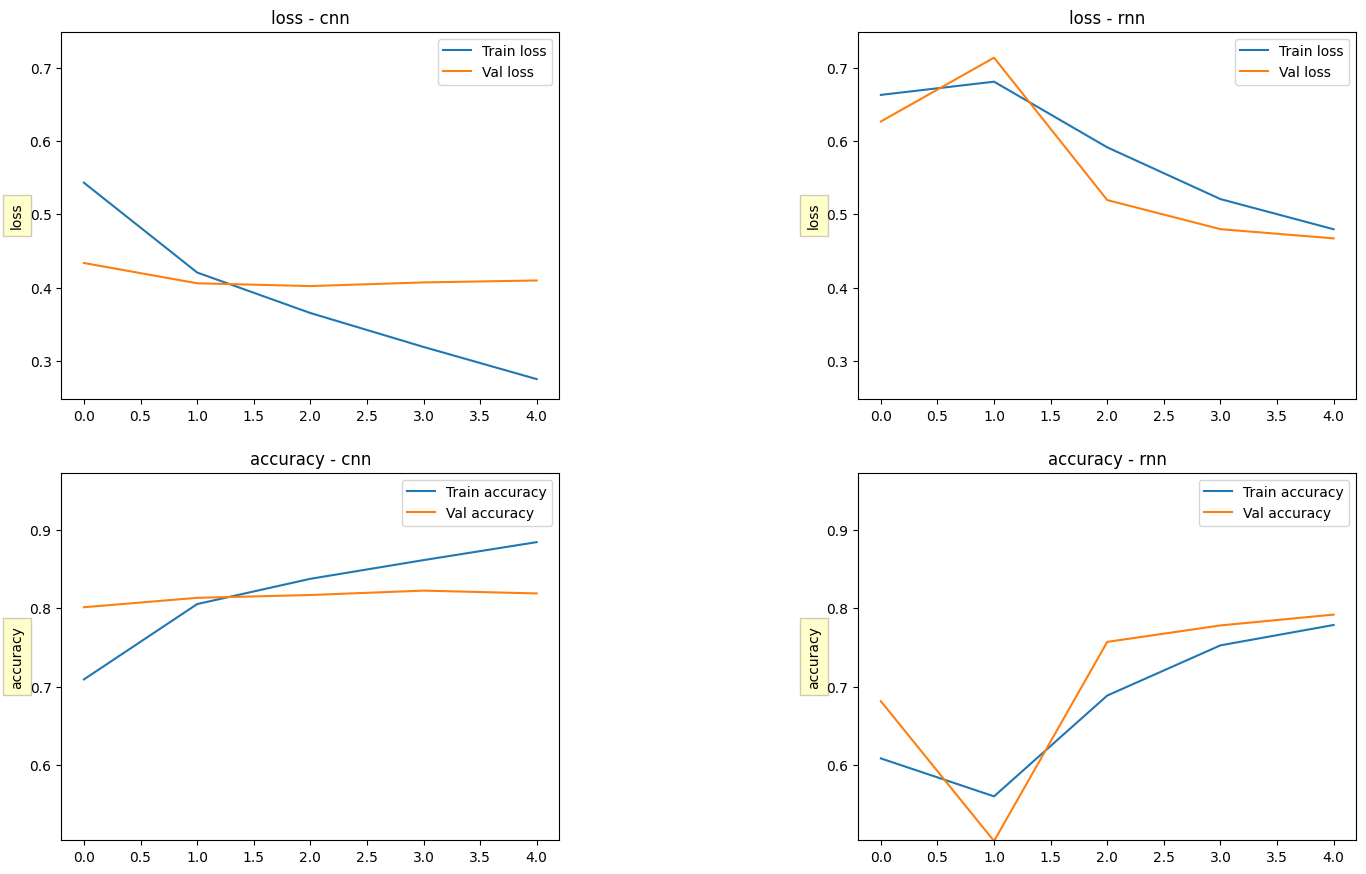

In [92]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          cnn_history,
          rnn_history,
          model_1_name='cnn',
          model_2_name='rnn')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

Got it 👍 — let’s unpack what you’re seeing in these **CNN vs RNN training/validation plots**.

---

### 1. Layout of the plots

* **Top row = loss curves**

  * Left = CNN (train/val loss)
  * Right = RNN (train/val loss)
* **Bottom row = accuracy curves**

  * Left = CNN (train/val accuracy)
  * Right = RNN (train/val accuracy)

Each x-axis is **epochs (0–4)**, and each y-axis is the corresponding metric (loss or accuracy).

---

### 2. CNN behavior

**Loss (top-left):**

* Training loss steadily decreases (0.55 → 0.27).
* Validation loss drops initially, then flattens \~0.41.
  👉 This suggests the CNN is fitting well, but possibly starting to **overfit** a little (train keeps improving, val stops).

**Accuracy (bottom-left):**

* Training accuracy improves steadily (0.71 → 0.89).
* Validation accuracy improves early, then plateaus (\~0.81–0.83).
  👉 The CNN quickly learns useful local features (n-gram patterns), then stops generalizing further after \~2 epochs.

---

### 3. RNN behavior

**Loss (top-right):**

* Training loss starts high, dips after epoch 2.
* Validation loss fluctuates more but improves after epoch 2.
  👉 RNN has **slower convergence** and is less stable early on.

**Accuracy (bottom-right):**

* Training accuracy actually dips in the first couple of epochs (from \~0.61 → 0.56), then recovers.
* Validation accuracy also dips (\~0.69 → 0.53), then jumps up strongly (\~0.79).
  👉 RNN needed a few epochs to **“stabilize” its memory usage**. After that, it catches up and matches/beat CNN val accuracy.

---

### 4. Takeaways

* **CNN**:

  * More stable training.
  * Good at capturing local text patterns quickly.
  * Risk of overfitting (train–val gap widens after 2 epochs).
* **RNN**:

  * Less stable early (gradient issues, more sensitive to initialization).
  * But eventually **generalizes better** (validation accuracy keeps climbing).
  * Learns long-range dependencies the CNN misses.

---

✅ **So overall:**

* CNN = fast, stable, strong baseline.
* RNN = slower, but might outperform CNN for tasks where sequence order/long-term context matters.

---

Do you want me to **add learning curves with both CNN and RNN on the same plot with legends** (so you can compare directly), instead of split 4 windows?


[Return to Top](#returnToTop)  
<a id = 'modelAttention'></a>

## 4. What about Attention?

Let us do a manual calculation with a simple set of queries and keys. (We'll use the keys as values as well, which is often done.)

In [93]:
test_query = np.array([[1.0, 2.0]])

test_keys_values = np.array([[[-1.0, 1.0], [5.0, -2.0]]])

What do we get with a manual calculation?

[back to slides](https://docs.google.com/presentation/d/1QL96CoLle8cgbrUB3uWuZ9hpKQ-MavOsKss1HGon2zE/edit#slide=id.p44)

Let's compare that to the result of the Keras attention calculation:

In [94]:
context_vectors, attention_scores = keras.layers.Attention()(
    [test_query, test_keys_values],
    return_attention_scores=True
)

In [95]:
print(context_vectors)

tf.Tensor([[[ 2.  -0.5]]], shape=(1, 1, 2), dtype=float32)


In [96]:
print(attention_scores)

tf.Tensor([[[0.5 0.5]]], shape=(1, 1, 2), dtype=float32)


Does that look right?

[Return to Top](#returnToTop)  
<a id = 'answers'></a>
## 5. Answers

**Question 3.4.2**:

The **Sequence Annotation Model** can model tasks like part of speech tagging or named entity tagging where a label must be assigned to each token.

The **Sequence to Vector Model** can model tasks like sentence  classification or can be used to generate a vector representing the text input that is then used by another model like an image generator.

The **Vector to Sequence Model** can model a task like image captioning where we pass a vector representation of an image into the model and it then generates a sequence of words in the caption.

The **Sequence to Sequence Model** (also known as an encoder-decoder model) can model a task like machine translation or summarization where you have an input text and we want to generate the appropriate corresponding output text.
